In [1]:
import pandas as pd
import re
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import spacy
import gensim.corpora as corpora
from pprint import pprint
from gensim.models import CoherenceModel, TfidfModel, Word2Vec, LsiModel, LdaMulticore, HdpModel, Phrases, phrases
import numpy as np
import pyLDAvis.gensim
import pyLDAvis
import nltk
from gensim.parsing.preprocessing import remove_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
sop = pd.read_csv('../data/sop.csv')

In [4]:
sop = sop.drop(['topic_id'], axis=1)

In [5]:
sop.sample(5)

,type,juri,role,sop,filename
731,SUICID,DE,dispatcher,Call from suicidal people Assign a member. Adv...,DE - SUICID - Suicidal person.docx
787,SUSPP,UN,call taker,Create a call If the caller can still see the ...,UN - SUSPP - Suspicious person.docx
64,FOUNDP,BI,call taker,Name unknown Create a call Questions: Is the n...,BI - FOUNDP - Found Person.docx
53,DOMI,RI,dispatcher,Assign two members.,RI - DOMI - Domestic in progress.docx
334,MISCHI,NW,dispatcher,Assign a member,NW - MISCHI - Mischief in Progress.docx


In [6]:
sop = sop[sop['role'] == 'call taker']

In [7]:
sop['sop_processed'] = sop['sop'].map(
    lambda x: re.sub('[,\.!?:]', '', str(x))
).map(
    lambda x: re.sub('\n', ' ', str(x))
)

<>:2: DeprecationWarning: invalid escape sequence \.
<>:2: DeprecationWarning: invalid escape sequence \.
<>:2: DeprecationWarning: invalid escape sequence \.
<ipython-input-7-f430529ab7ed>:2: DeprecationWarning: invalid escape sequence \.
  lambda x: re.sub('[,\.!?:]', '', str(x))


In [8]:
sop['sop_processed'] = sop['sop_processed'].map(lambda x: x.lower().strip())
sop = sop[sop['sop_processed'] != '']

In [9]:
sop.sample(5)

,type,juri,role,sop,filename,sop_processed
38,DOMI,RI,call taker,Create a call in every instance. Do not cancel...,RI - DOMI - Domestic in progress.docx,create a call in every instance do not cancel ...
14,1033,WP,call taker,Create a call Questions Are there weapons invo...,WP - 1033 - Officer in trouble.docx,create a call questions are there weapons invo...
2074,MARINE,NW,call taker,Create a call Questions Where is the vessel? (...,NW - MARINE - Marine Incident.docx,create a call questions where is the vessel (e...
235,JUMPER,WP,call taker,Bridge Create a call Questions: Which end and ...,WP - JUMPER.docx,bridge create a call questions which end and w...
1424,MISSIP,VA,call taker,Questions Is the missing person 12 years old o...,VA - MISSIP - Missing person.docx,questions is the missing person 12 years old o...


In [10]:
sop.shape

(1468, 6)

In [11]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True))

In [12]:
data = sop.sop_processed.values.tolist()
data_words = np.array(list(sent_to_words(data)))

In [13]:
def remove_stopwords_docs(texts):
    return [simple_preprocess(remove_stopwords(' '.join(doc))) for doc in texts]

In [14]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(' '.join(sent))
        texts_out.append([
            token.lemma_ for token in doc if token.pos_ in allowed_postags or '_' in token.lemma_
        ])
        
    return texts_out

In [15]:
data_words_nostops = remove_stopwords_docs(data_words)

# data_words_nostops = data_words

In [16]:
bigram = Phrases(data_words, min_count=1, threshold=1)
trigram = Phrases(bigram[data_words], threshold=1)

In [17]:
bigram_mod = phrases.Phraser(bigram)
trigram_mod = phrases.Phraser(trigram)

In [18]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram[doc]] for doc in texts]

In [19]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [20]:
data_lemmatized = lemmatization(make_bigrams(data_words_nostops))

In [21]:
sop['sop_processed'] = data_lemmatized

In [22]:
sop['sop_processed'] = sop['sop_processed'].apply(lambda x: ' '.join(x))

In [23]:
sop.iloc[50]['sop']

'Natural Gas Leaks and Chemical Spills Hazardous material includes any product, which is flammable, toxic, explosive, corrosive, poisonous, or radioactive. Public caller: Create a call Downstream to Fire Fire calling for assistance see ASSPFA SOPs Wires Down Create a call, if wires sparking or jumping upgrade to Priority 1 Advise caller to stay clear of wires down Downstream to Fire Suspicious Powder in Packages or Letters Create a call Obtain the following: Exact location of the package or letter What makes the caller believe the package is contaminated When was package received? Has anyone had contact with the substance? If Yes, when and what kind of contact Is the person(s) having any symptoms? If Yes, advise BCAS Where are all parties that have had contact with the package? Advise the caller: To not move the package To stay well clear of the package and to keep others well away until emergency responders arrive on scene Stalled Vehicle on Highway or Bridge Create a call Obtain vehi

In [24]:
sop.iloc[50]['sop_processed']

'natural_gas chemical_spills hazardous_material include product flammable_toxic explosive_corrosive poisonous radioactive_public caller create downstream call assistance asspfa_sop wire create wires_sparking jumping_upgrade priority advise caller stay_clear wire downstream suspicious_powder package letters_create obtain following_exact location package letter make caller_believe package contaminate package_received contact substance kind contact person_having symptom yes_advise bcas party contact package_advise caller package stay_clear package away emergency_responder arrive scene_stalled vehicle highway bridge_create obtain vehicle_description licence_plate enter remark vehicle impeding_traffic person_walking shoulder highway_create obtain_description debris_obstructe traffic highway_create'

In [25]:
id2word = corpora.Dictionary(data_lemmatized)

texts = data_lemmatized

corpus = [id2word.doc2bow(text) for text in texts]

tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [26]:
def turn_tfidf_corpus(texts, id2word = id2word):
    corpus = [id2word.doc2bow(simple_preprocess(text)) for text in texts]
    tfidf = TfidfModel(corpus)
    return tfidf[corpus]

In [27]:
hdp_model_tfidf = HdpModel(corpus=corpus_tfidf, id2word=id2word, alpha=0.001, gamma=0.001)

In [28]:
coherence_hdp_tfidf = CoherenceModel(model=hdp_model_tfidf, texts=texts, dictionary=id2word, coherence='c_v')

In [29]:
coherence_hdp_tfidf.get_coherence()

0.7404287646130596

In [30]:
hdp_model_tfidf.get_topics().shape

(150, 3037)

In [31]:
len(sop['type'].unique())

96

In [32]:
abduc_sop = sop[sop['type'] == 'ABDUC']

In [33]:
tfidf_new_corpus = turn_tfidf_corpus(abduc_sop['sop_processed'])

In [49]:
abduc_sop

,type,juri,role,sop,filename,sop_processed
1770,ABDUC,AB,call taker,Caller witnesses someone who appears to be tak...,AB - ABDUC - Abduction.docx,caller_witnesses appear take suspicious_circum...
1771,ABDUC,BU,call taker,Caller witnesses someone who appears to be tak...,BU - ABDUC - Abduction.docx,caller_witnesses appear take suspc_suspicious ...
1772,ABDUC,RI,call taker,Caller witnesses someone who appears to be tak...,RI - ABDUC - Abduction.docx,caller_witnesses appear take suspc_suspicious ...
1773,ABDUC,RM,call taker,Caller witnesses someone who appears to be tak...,RM - ABDUC - Abduction.docx,caller_witnesses appear take suspc_suspicious ...
1774,ABDUC,BI,call taker,Caller witnesses someone who appears to be tak...,BI - ABDUC - Abduction.docx,caller_witnesses appear take suspc_suspicious ...
1775,ABDUC,DE,call taker,Caller witnesses someone who appears to be tak...,DE - ABDUC - Abduction.docx,caller_witnesses appear take suspc_suspicious ...
1776,ABDUC,SC,call taker,Caller witnesses someone who appears to be tak...,SC - ABDUC - Abduction.docx,caller_witnesses appear take suspc_suspicious ...
1777,ABDUC,SQ,call taker,Caller witnesses someone who appears to be tak...,SQ - ABDUC - Abduction.docx,caller_witnesses appear take suspc_suspicious ...
1778,ABDUC,SX,call taker,Caller witnesses someone who appears to be tak...,SX - ABDUC - Abduction.docx,caller_witnesses appear take suspc_suspicious ...
1779,ABDUC,UN,call taker,Caller witnesses someone who appears to be tak...,UN - ABDUC - Abduction.docx,caller_witnesses appear take suspc_suspicious ...


In [34]:
for topic in hdp_model_tfidf[tfidf_new_corpus]:
    print(topic)

[(45, 0.9997879998158644)]
[(45, 0.9997842192813542)]
[(45, 0.9997842192813542)]
[(45, 0.9997842192813542)]
[(86, 0.99937441878039)]
[(126, 0.9992099085234787)]
[(86, 0.99937441878039)]
[(86, 0.99937441878039)]
[(86, 0.99937441878039)]
[(86, 0.99937441878039)]
[(126, 0.9992099085234787)]
[(86, 0.99937441878039)]
[(77, 0.4671438216282207), (141, 0.5326444000143733)]
[(80, 0.5800858838347678), (141, 0.4197134121720046)]
[(77, 0.4671438216282207), (141, 0.5326444000143733)]


In [35]:
hdp_model_tfidf.print_topic(37, topn=20)

'0.002*"fraud_involves" + 0.002*"scene_avoid" + 0.002*"enter_sisterwatch" + 0.002*"case" + 0.002*"son" + 0.002*"health_care" + 0.002*"start" + 0.002*"payphone" + 0.002*"code_word" + 0.002*"attach_ani" + 0.002*"school_day" + 0.002*"bylaws_spca" + 0.002*"animal_bites" + 0.002*"steal" + 0.002*"enroute_question" + 0.002*"corporation" + 0.002*"company_policies" + 0.002*"frequent_callers" + 0.002*"estimate" + 0.002*"dispatcher_missing"'

In [36]:
hdp_model_tfidf.print_topic(60, topn=20)

'0.003*"surrender" + 0.003*"weekend" + 0.002*"alcohol_involve" + 0.002*"animal_bite" + 0.002*"wires_sparking" + 0.002*"bowen_island" + 0.002*"low_risk" + 0.002*"incident_include" + 0.002*"shift" + 0.002*"grandpa_basement" + 0.002*"order" + 0.002*"remarks_registered" + 0.002*"requires_urgent" + 0.002*"information_verbally" + 0.002*"town" + 0.002*"hunt" + 0.002*"kick" + 0.002*"description_originating" + 0.002*"religious" + 0.002*"coordinate"'

In [37]:
abduc_sop_head_4 = abduc_sop.head(4)

In [44]:
vectorizer = TfidfVectorizer()
vectorizer.fit(abduc_sop_head_4['sop'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [45]:
def word_cloud_tfidf(words):
    tdm = vectorizer.transform(words)
    freqs = dict([(word, tdm.getcol(idx).sum()) for word, idx in vectorizer.vocabulary_.items()])
    w = WordCloud(width=800, height=400, mode='RGBA', background_color='white', max_words=2000).fit_words(freqs)
    plt.figure(figsize=(12, 6))
    plt.imshow(w)
    plt.show()

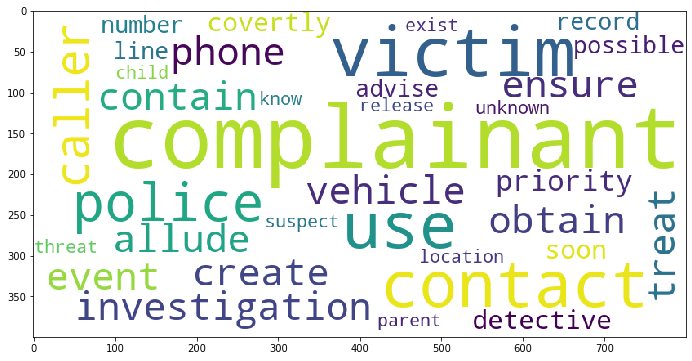

In [46]:
word_cloud_tfidf([abduc_sop.iloc[0]['sop_processed']])

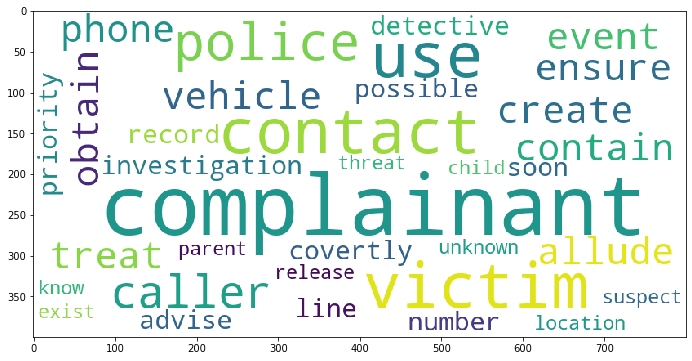

In [47]:
word_cloud_tfidf([abduc_sop.iloc[1]['sop_processed']])

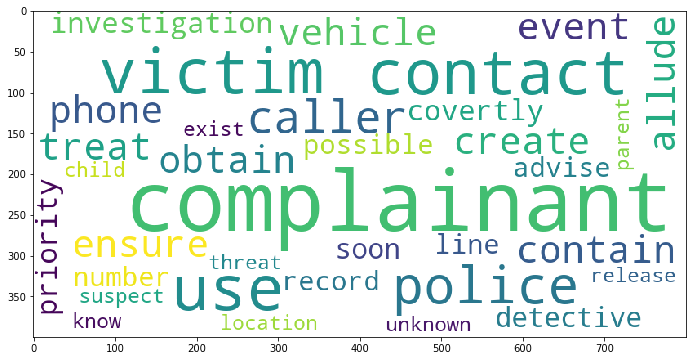

In [48]:
word_cloud_tfidf([abduc_sop.iloc[2]['sop_processed']])